## Перенос стиля

### Импорт необходимых библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [3]:
path_to_dataset = Path("/content/drive/MyDrive/images") #Путь к датасету с изображениями
path_to_dataset

PosixPath('/content/drive/MyDrive/images')

### Загрузка изображений

In [4]:
imsize = 256

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

def image_loader(image_name): #Функция преобразования изображения в тензор
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

#Выбор изображений стиля и контента
style_img1 = image_loader(path_to_dataset/"dali.jpg")
style_img2 = image_loader(path_to_dataset/"fovism.jpg")
style_img3 = image_loader(path_to_dataset/"munch.jpg")
style_img4 = image_loader(path_to_dataset/"stone.jpg")
content_img = image_loader(path_to_dataset/"me.jpg")
style_imgs = [style_img1, style_img2, style_img3, style_img4] #Список с изображениями стиля

Используемое устройство: cuda


### Вывод загруженных изображений стиля и контента

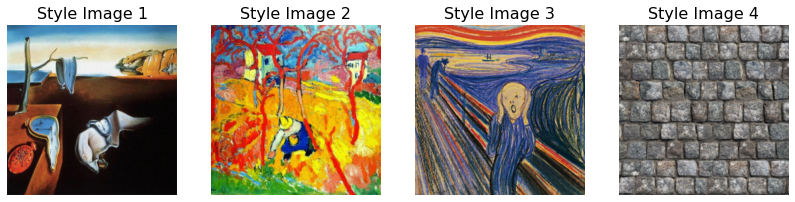

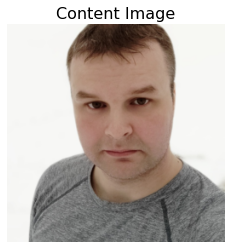

In [5]:
unloader = transforms.ToPILImage() # тензор в кратинку  


def imshow(tensor, axes, title=None):  # функция для отрисовки изображения
    image = tensor.cpu().clone()   
    image = image.squeeze(0)     
    image = unloader(image)
    axes.axis("off")
    axes.imshow(image)
    if title is not None:
        axes.set_title(title, fontsize = 16)
    


# отрисовка

fig, ax = plt.subplots(1,len(style_imgs), figsize = (14, 8))
for i in range(len(style_imgs)):
    imshow(style_imgs[i], ax[i], title=f'Style Image {i+1}')

fig, ax = plt.subplots(figsize = (8, 4))
imshow(content_img, ax, title='Content Image')

### Класс для Content Loss

In [6]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()                     #Это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target ) #Осуществляем инициализацию

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

### Функция вычисления матрицы Грама

In [7]:
def gram_matrix(input): #Функция вычисления матрицы Грама
        batch_size , f_map_num, h, w = input.size()  # batch size(=1)
        features = input.view(batch_size * f_map_num, w * h)  
        G = torch.mm(features, features.t()) 
        return G.div(batch_size * h * w * f_map_num)

### Функция применения маски

Для применения нескольких стилей на частях одной картинки необходимо использовать маски. Маска зануляет ту часть изображения или feature map, к которой стиль применяться не будет. Ту же часть, к которой стиль применяется, маска не изменяет. Будем использовать четыре режима (mode) применения стилей:
- ver: картинка разделяется по вертикали на две части, к каждой части применяется свой стиль;
- hor: картинка разделяется по горизонтали на две части, к каждой части применяется свой стиль;
- cross: картинка делится на четыре части, к каждой применяется свой стиль;
- all: применение нескольких стилей сразу ко всей картинке в целом. <br>

Каждая из масок ver, hor, cross имеет дополнительный параметр number, указывающий на то, к какой именно части картинки применяется стиль.

In [8]:
def create_mask(tensor, mode, number):
    size_mask = list(tensor.size())
    h, w = size_mask[2:]
    
    if mode == "hor":
        size_mask[2] = h//2
        if number == 0:
            a = torch.ones(size_mask)
            b = torch.zeros(size_mask)
        else:
            a = torch.zeros(size_mask)
            b = torch.ones(size_mask)
        c = torch.cat((a, b), dim = 2)
        
    elif mode == "ver":
        size_mask[3] = w//2
        if number == 0:
            a = torch.ones(size_mask)
            b = torch.zeros(size_mask)
        else:
            a = torch.zeros(size_mask)
            b = torch.ones(size_mask)
        c = torch.cat((a, b), dim = 3)
        
    elif mode == "all":
        c = torch.ones(size_mask)
        
    elif mode == "cross":
        size_mask[2] = h//2
        size_mask[3] = w//2
        e = torch.ones(size_mask)
        z = torch.zeros(size_mask)
        if number == 0:
            a = torch.cat((e, z), dim = 3)
            b = torch.cat((z, z), dim = 3)
        elif number == 1:
            a = torch.cat((z, e), dim = 3)
            b = torch.cat((z, z), dim = 3)
        elif number == 2:
            a = torch.cat((z, z), dim = 3)
            b = torch.cat((e, z), dim = 3)
        else:
            a = torch.cat((z, z), dim = 3)
            b = torch.cat((z, e), dim = 3)
        c = torch.cat((a, b), dim = 2)
        
        
    c = c.to(device)
    
    return c*tensor

Продемонстрируем применение масок к content image:

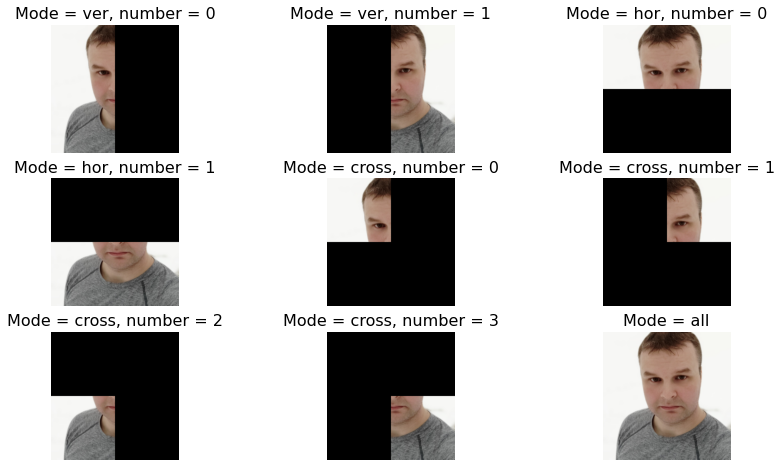

In [9]:
fig, ax = plt.subplots(3, 3, figsize = (14, 8))
imshow(create_mask(content_img, "ver", 0), ax[0, 0], "Mode = ver, number = 0")
imshow(create_mask(content_img, "ver", 1), ax[0, 1], "Mode = ver, number = 1")
imshow(create_mask(content_img, "hor", 0), ax[0, 2], "Mode = hor, number = 0")
imshow(create_mask(content_img, "hor", 1), ax[1, 0], "Mode = hor, number = 1")
imshow(create_mask(content_img, "cross", 0), ax[1, 1], "Mode = cross, number = 0")
imshow(create_mask(content_img, "cross", 1), ax[1, 2], "Mode = cross, number = 1")
imshow(create_mask(content_img, "cross", 2), ax[2, 0], "Mode = cross, number = 2")
imshow(create_mask(content_img, "cross", 3), ax[2, 1], "Mode = cross, number = 3")
imshow(create_mask(content_img, "all", 0), ax[2, 2], "Mode = all")

### Класс для Style Loss

Перед вычислением матрицы Грама от тензора input (представляющего собой некоторый feature map), поступающего на вход слоя, являющегося экземпляром класса StyleLoss, мы применяем к input маску с помощью функции create_mask. Этого достаточно для требуемой работы алгоритма градиентного спуска: части feature map, "накрытые" черными областями маски, изменяться не будут. Однако, для лучшей стабильности будем применять ту же маску и к target feature map на входе этого же слоя перед вычислением матрицы Грама от target feature map. Это помогает при делении картинки на четыре части избежать ситуации, когда изменяемая часть Style Loss оказывается в несколько раз меньше, чем неизменяемая.Грубо говоря, в режиме cross 3/4 общего содержимого feature map после применения маски оказывается нулями, тогда как в target feature map без маски эти 3/4 - не нули, и mse_loss теоретически не может упасть ниже усредненной суммы квадратов 3/4 от общего количества элементов в матрице Грама от target feature map (неизменяемая часть лосса)). После применения маски к target feature map не остатется этой теоретически минимальной части лосса, что положительно сказывается на стабильности сходимости (установлено экспериментально).

In [10]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature, mode, number):
            super(StyleLoss, self).__init__()
            self.mode = mode
            self.number = number
            self.target = gram_matrix(create_mask(target_feature, self.mode, self.number)).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):                       
            G = gram_matrix(create_mask(input, self.mode, self.number))
            self.loss = F.mse_loss(G, self.target)
            return input

### Нормализация

При тренировке VGG каждое изображение, на котором она обучалась, было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [12]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

### Слои стиля и слои контента

In [13]:
content_layers_default = ['conv_4', 'conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7']

Определим предобученную модель

In [14]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


### Функция создания модели 

In [15]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_imgs, content_img, mode, 
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        
        #style_imgs - список из тензоров стилевых картинок, mode - режим применения стиля, соответствующий параметру mode функции
        #create_mask
        cnn = copy.deepcopy(cnn)
        normalization = Normalization(normalization_mean, normalization_std).to(device)
        content_losses = []
        #Список style_loss состоит из вложенных списков, каждый из которых содержит все слои модели, соответствующие текущему стилю.
        #Число вложенных списков равно числу стилей.
        style_losses = []
        for k in range(len(style_imgs)):
            style_losses.append([])
        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                #После каждого слоя из style_layers, добавляется n слоев типа StyleLoss (где n - число стилей)
                for j, style_img in enumerate(style_imgs):
                    target_feature = model(style_img).detach()
                    style_loss = StyleLoss(target_feature, mode, j)
                    model.add_module(f"style_loss{i}_{j}", style_loss)
                    style_losses[j].append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

### Оптимайзер

In [16]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

### Цикл обучения

В функцию run_style_transfer добавлен параметр verbosity, который определяет, будут ли выводиться на экран промежуточные значения лоссов и выходной картинки в процессе итераций. Реализован достаточно богатый функционал по применению стилей: можно применять стили к частям картинки, в том числе с разными весами. Ограничения по разбиению картинки на части связаны с реализованными масками: можно разбить картинку на две части по горизонтали, на две по вертикали, или на четыре части. Что касается совместного применения стилей ко всей картинке, то их количество жестко ничем не ограничено: сколько будет передано тензоров картинок в списке style_imgs, столько стилей и будет применено совместно.

In [17]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_imgs, input_img, mode, num_steps=1000,
                        style_weights=[2000], content_weight=5e-4, verbosity = True):
        """Run the style transfer."""
        #style_weights - список весов, соответствующих стилям
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_imgs, content_img, mode)
        optimizer = get_input_optimizer(input_img)
        style_weights = torch.cuda.FloatTensor(style_weights)
        print('Optimizing..')
        if verbosity:
            fig, ax = plt.subplots(2, int(np.ceil(num_steps/200)), figsize = (14, 6))
            axc = ax.ravel()
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_scores = torch.zeros(len(style_imgs)).to(device)
                content_score = 0
                for i, sl in enumerate(style_losses):
                    for layer in sl:
                        style_scores[i] += layer.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_scores *= style_weights
                style_score = style_scores.sum()
                content_score *= content_weight
                
                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    if verbosity:
                        print("run {}:".format(run))
                        print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score, content_score))
                        print()
                        if run[0]%100 == 0:
                            k = run[0]//100
                            imshow(input_img, axc[k-1], title= f'После {run[0]} итераций')
                           
                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)
        if verbosity:
            plt.tight_layout()
            plt.show()
        return input_img

### Демонстрация работы: применение одного стиля, стартовое изображение - Content Image

Ставим режим mode = "all" (применение стиля ко всей картинке), style_imgs и style_weights по синтаксису обязаны быть списками, поэтому в данном случае это списки, содержащие один элемент.

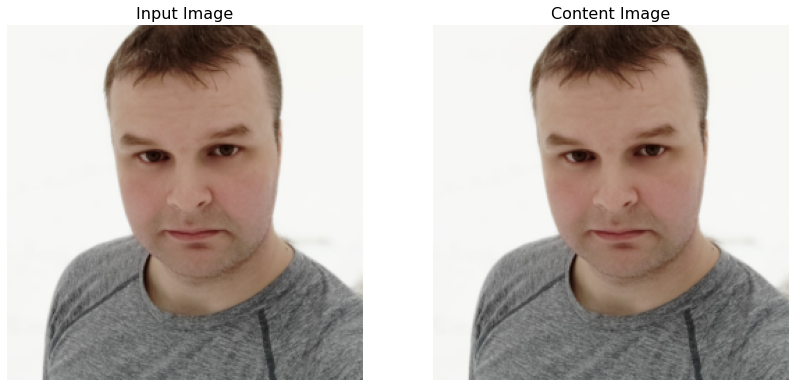

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.811678 Content Loss: 1.015754

run [100]:
Style Loss : 0.808600 Content Loss: 1.015708

run [150]:
Style Loss : 0.465159 Content Loss: 1.005750

run [200]:
Style Loss : 0.284787 Content Loss: 0.995087

run [250]:
Style Loss : 0.186968 Content Loss: 0.981026

run [300]:
Style Loss : 0.133577 Content Loss: 0.972118

run [350]:
Style Loss : 0.102780 Content Loss: 0.962628

run [400]:
Style Loss : 0.086793 Content Loss: 0.952372

run [450]:
Style Loss : 0.075188 Content Loss: 0.946692

run [500]:
Style Loss : 0.068979 Content Loss: 0.939231

run [550]:
Style Loss : 0.061061 Content Loss: 0.935493

run [600]:
Style Loss : 0.069073 Content Loss: 0.927732

run [650]:
Style Loss : 0.052912 Content Loss: 0.927708

run [700]:
Style Loss : 0.050328 Content Loss: 0.924220

run [750]:
Style Loss : 0.050196 Content Loss: 0.921069

run [800]:
Style Loss : 0.048466 Content Loss: 0.917452

run [850]:
Style Loss : 0.044101 Content

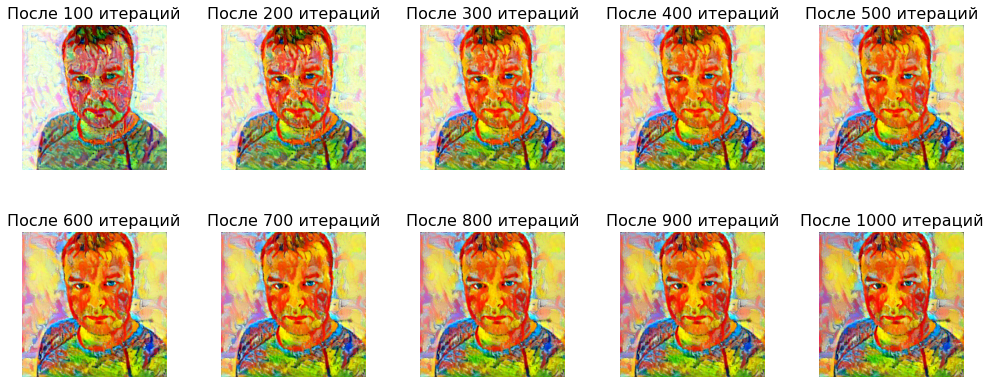

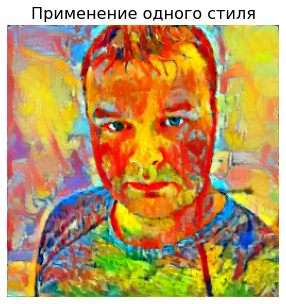

In [18]:
input_img = copy.deepcopy(content_img)
fig, ax = plt.subplots(1, 2, figsize = (14, 8))
imshow(input_img, ax[0], title='Input Image')
imshow(content_img, ax[1], title='Content Image')
plt.show()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs[1:2], input_img, mode = "all", style_weights = [800], content_weight=5e-3)
fig, ax = plt.subplots(figsize = (10, 5))
imshow(output, ax, title='Применение одного стиля')
plt.show()

### Демонстрация работы: применение одного стиля, стартовое изображение - шум

Посмотрим теперь, как картинка будет восстанавливаться из гауссового шума. Видим, что итоговое изображение более зернистое и субъективно приятнее смотреть на картинку, стартовавшую с Content Image, поэтому далее в качестве input_img будем использовать Content Image.

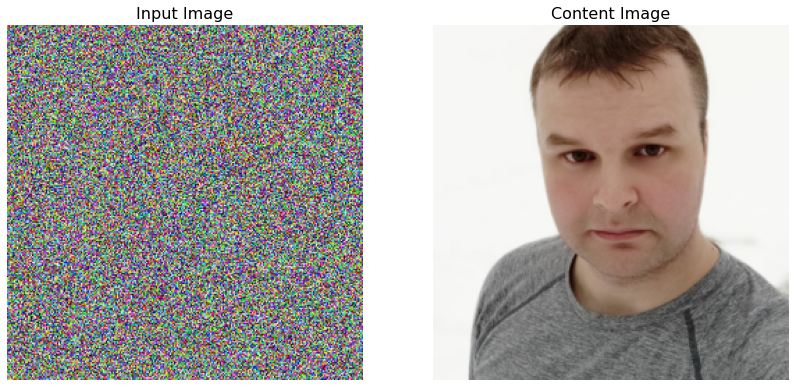

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.962991 Content Loss: 1.236369

run [100]:
Style Loss : 1.017115 Content Loss: 1.202379

run [150]:
Style Loss : 0.589382 Content Loss: 1.167122

run [200]:
Style Loss : 0.408654 Content Loss: 1.127768

run [250]:
Style Loss : 0.291669 Content Loss: 1.100792

run [300]:
Style Loss : 0.211508 Content Loss: 1.079270

run [350]:
Style Loss : 0.160434 Content Loss: 1.059791

run [400]:
Style Loss : 0.124224 Content Loss: 1.041948

run [450]:
Style Loss : 0.099978 Content Loss: 1.026128

run [500]:
Style Loss : 0.083460 Content Loss: 1.012839

run [550]:
Style Loss : 0.076276 Content Loss: 1.000399

run [600]:
Style Loss : 0.063308 Content Loss: 0.991694

run [650]:
Style Loss : 0.060936 Content Loss: 0.982062

run [700]:
Style Loss : 0.072982 Content Loss: 0.973473

run [750]:
Style Loss : 0.051867 Content Loss: 0.966908

run [800]:
Style Loss : 0.058525 Content Loss: 0.958447

run [850]:
Style Loss : 0.047501 Content

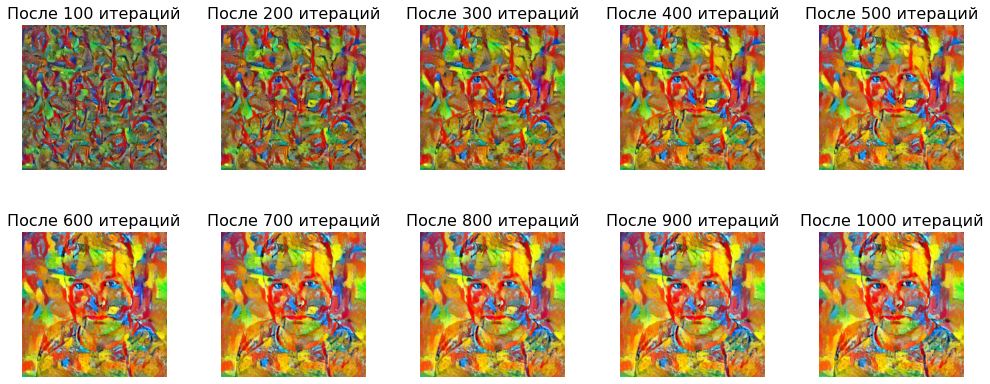

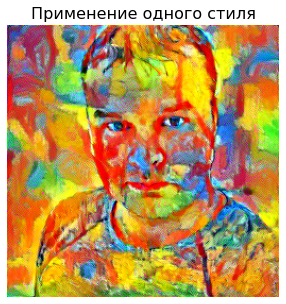

In [19]:
input_img = torch.randn(content_img.size()).to(device)
fig, ax = plt.subplots(1, 2, figsize = (14, 8))
imshow(input_img, ax[0], title='Input Image')
imshow(content_img, ax[1], title='Content Image')
plt.show()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs[1:2], input_img, mode = "all", style_weights = [800], content_weight=5e-3)
fig, ax = plt.subplots(figsize = (10, 5))
imshow(output, ax, title='Применение одного стиля')
plt.show()

### Демонстрация работы: применение двух стилей к разным частям картинки

Применим стили к разделенной по горизонтали и разделенной по вертикали картинкам. Поскольку на каждой части картинки применен только один стиль, то веса стилей берем равными (при неравных весах стилей часть картинки с меньшим весом просто будет больше похожа на исходное изображение, и это не особо информативно).

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


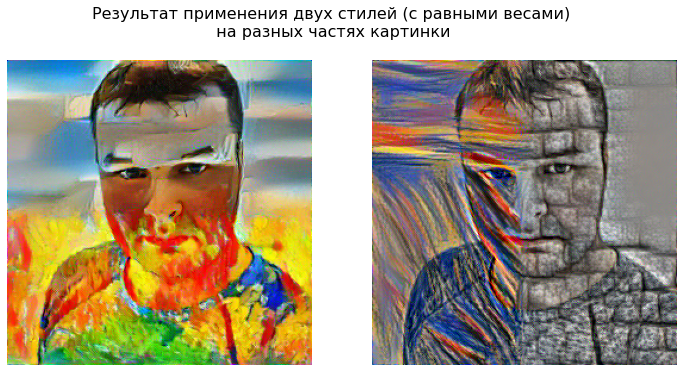

In [20]:
input_img1 = copy.deepcopy(content_img)
input_img2 = copy.deepcopy(content_img)
output1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
          content_img, style_imgs[:2], input_img1, mode = "hor", style_weights = [800, 800], content_weight=5e-3, verbosity = False)
output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
          content_img, style_imgs[2:], input_img2, mode = "ver", style_weights = [800, 800], content_weight=5e-3, verbosity = False)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
imshow(output1, ax[0])
imshow(output2, ax[1])
plt.suptitle("Результат применения двух стилей (c равными весами)\n на разных частях картинки", fontsize = 16)
plt.show()

### Демонстрация работы: применение нескольких стилей одновременно ко всей картинке

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


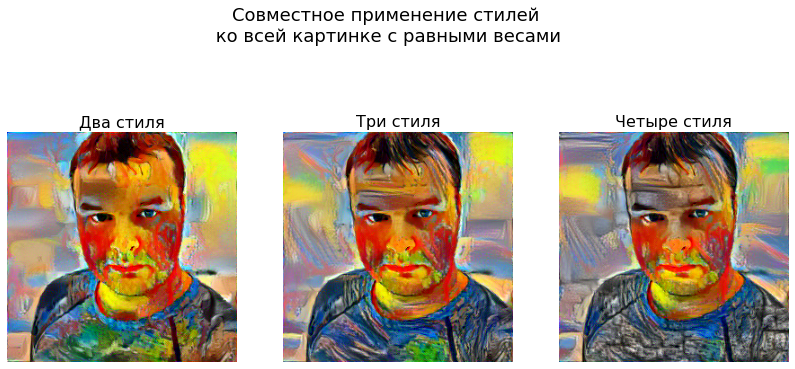

In [21]:
input_img1 = copy.deepcopy(content_img)
input_img2 = copy.deepcopy(content_img)
input_img3 = copy.deepcopy(content_img)

output1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
          content_img, style_imgs[:2], input_img1, mode = "all", style_weights = [1000, 1000], content_weight=1e-2, verbosity = False)
output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
          content_img, style_imgs[:3], input_img2, mode = "all", style_weights = [1000, 1000, 1000], content_weight=1e-2, verbosity = False)
output3 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
          content_img, style_imgs, input_img3, mode = "all", style_weights = [1000, 1000, 1000, 1000], content_weight=1e-2, verbosity = False)


fig, ax = plt.subplots(1, 3, figsize = (14, 7))
imshow(output1, ax[0], title = "Два стиля")
imshow(output2, ax[1], title = "Три стиля")
imshow(output3, ax[2], title = "Четыре стиля")
plt.suptitle("Совместное применение стилей\n ко всей картинке с равными весами", fontsize = 18)
plt.show()

### Демонстрация работы: применение двух стилей с разными весами одновременно ко всей картинке

Применяются два стиля: картина Мунка "Крик" и каменная текстура. На левой картинке видно преобладание стилевых черт, характерных для картины Мунка, на правой - для каменной текстуры.

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


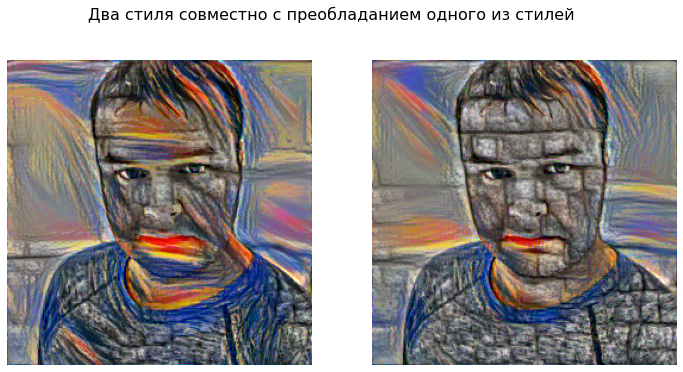

In [22]:
input_img1 = copy.deepcopy(content_img)
input_img2 = copy.deepcopy(content_img)
output1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
          content_img, style_imgs[2:], input_img1, mode = "all", style_weights = [1000, 500], content_weight=5e-3, verbosity = False)
output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
          content_img, style_imgs[2:], input_img2, mode = "all", style_weights = [500, 1000], content_weight=5e-3, verbosity = False)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
imshow(output1, ax[0])
imshow(output2, ax[1])
plt.suptitle("Два стиля совместно с преобладанием одного из стилей", fontsize = 16)
plt.show()

### Демонстрация работы: применение стиля к половине картинки

Следствием того, что реализована возможность применения стилей с весами, является возможность применть стиль только к половине картинки, а другую половину оставить неизменной. Для этого достаточно занулить вес одного из двух применяемых стилей.

Building the style transfer model..
Optimizing..


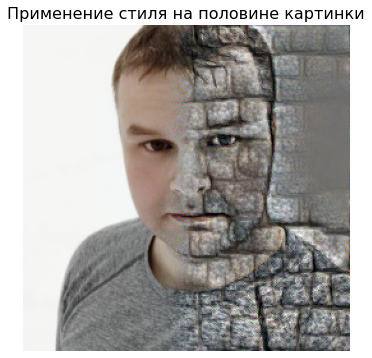

In [28]:
input_img = copy.deepcopy(content_img)
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
        content_img, style_imgs[2:], input_img, mode = "ver", style_weights = [0, 1000], content_weight=3e-3, verbosity = False)
fig, ax = plt.subplots(figsize = (12, 6))
imshow(output, ax, title='Применение стиля на половине картинки')
plt.show();

### Демонстрация работы: применение четырех стилей (с равными весами) на разных частях картинки

Наконец, применим четыре стиля к разным частям картинки и посмотрим на результат.

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.434972 Content Loss: 0.559648

run [100]:
Style Loss : 0.216778 Content Loss: 0.547401

run [150]:
Style Loss : 0.157526 Content Loss: 0.536352

run [200]:
Style Loss : 0.121299 Content Loss: 0.530218

run [250]:
Style Loss : 0.103396 Content Loss: 0.522481

run [300]:
Style Loss : 0.092701 Content Loss: 0.518458

run [350]:
Style Loss : 0.083566 Content Loss: 0.515725

run [400]:
Style Loss : 0.076719 Content Loss: 0.513589

run [450]:
Style Loss : 0.072127 Content Loss: 0.511550

run [500]:
Style Loss : 0.068739 Content Loss: 0.509835

run [550]:
Style Loss : 0.066268 Content Loss: 0.508647

run [600]:
Style Loss : 0.064433 Content Loss: 0.507552

run [650]:
Style Loss : 0.063502 Content Loss: 0.506297

run [700]:
Style Loss : 0.061999 Content Loss: 0.505906

run [750]:
Style Loss : 0.061701 Content Loss: 0.504948

run [800]:
Style Loss : 0.060689 Content Loss: 0.504554

run [850]:
Style Loss : 0.060335 Content

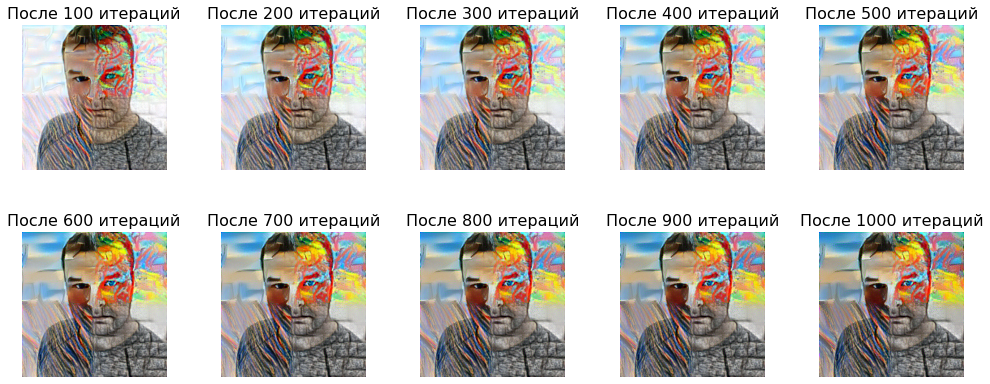

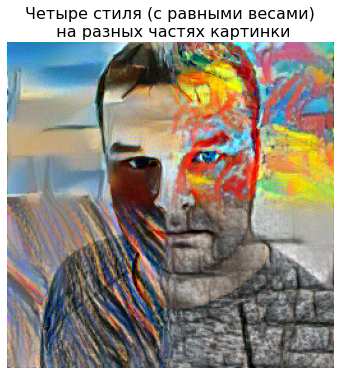

In [23]:
input_img = copy.deepcopy(content_img)
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
        content_img, style_imgs, input_img, mode = "cross", style_weights = [1000, 1000, 1000, 1000], content_weight=5e-3)
fig, ax = plt.subplots(figsize = (12, 6))
imshow(output, ax, title='Четыре стиля (c равными весами)\n на разных частях картинки')
plt.show();